### Application of $\chi^2$ on ASCAD

On a per-sample-point basis.

In [1]:
import math
from random import choices
import numpy as np
import seaborn as sns
from tqdm import tqdm
from tools.cache import cache_np
from tools.nbloader import NotebookLoader

from tools.traceloader import ASCAD, TraceGroup

sns.set_style("whitegrid")

In [2]:
SLIDING_WINDOW_SIZE = 1
NUM_BINS = 64

ascad = ASCAD()
ascad.default.profile.traces.shape

(200000, 1400)

In [3]:
chi_squared = NotebookLoader(["../tvla"]).load_module("chi2").chi_squared

importing Jupyter notebook from ../tvla/chi2.ipynb


In [4]:
def count_sample_point(traces: np.array):
    """
    Simple bin count that counts occurrences of a power trace value ([0..256] for ASCAD) per sample point.
    """
    return np.array([np.bincount(t, minlength=ASCAD.key_size) for t in np.moveaxis(traces, 0, -1) + (-ASCAD.offset)],
                    dtype=np.uint32)

In [5]:
def reduce_bin_count(bin_count: np.array, bins_from: int, bins_to: int):
    """
    Reduces the number of bins from a bin count.
    """
    res = np.zeros(bins_to, dtype=np.uint32)
    step = round(bins_from / bins_to) # Should be divisible

    for ix in range(bins_to):
        res[ix] = np.sum(bin_count[ix * step:(ix + 1) * step])

    return res

def count(traces: np.array, window_size=SLIDING_WINDOW_SIZE, bin_count=NUM_BINS):
    """
    Extended bin count that counts the occurrences of a power trace value ([0..256] for ASCAD) per sliding window step.

    @param traces: Array of traces.
    @param window_size: The sliding window size. The window step is fixed to 1.
    @param bin_count: The number of bins the bin count should be reduced to.
    """
    ts = np.moveaxis(traces, 0, -1) + (-ASCAD.offset)
    t_size = ts.shape[0]
    res = np.array([np.zeros(bin_count)] * t_size, dtype=np.uint32)

    max_win_ix = t_size - window_size + 1
    win_range = range(max_win_ix)

    for ix in win_range:
        bc = np.zeros(ASCAD.key_size)
        for t in ts[ix:ix + window_size]:
            bc += np.array(np.bincount(t, minlength=ASCAD.key_size), dtype=np.uint32)
        res[ix] = reduce_bin_count(bc, ASCAD.key_size, bin_count)

    return res


# The sum of bin counts with window = 1 should be equal to the sample-point bin count.
assert count(ascad.default.profile.filter_traces(0), 1).sum() - \
       count_sample_point(ascad.default.profile.filter_traces(0)).sum() == 0

In [6]:
def balance_count(traces, max_len=None, sw_size=SLIDING_WINDOW_SIZE):
    """
    Balances the bin count sum by randomly incrementing counters using the existing distribution from the bin count.
    Useful when dealing with trace sets that are not of the same size.
    """
    num_traces, trace_size = traces.shape

    split = fill = round(num_traces / 2)
    if max_len is None:
        # If the trace length to matched is given.
        fill = math.ceil(num_traces / 2)

    cnt = lambda a: count(a, sw_size)
    left, right = cnt(traces[split:]), cnt(traces[:split])

    cs = lambda w, k: choices(list(range(left.shape[1])), weights=w, k=k)

    # Get the number of draws per sliding window index.
    draw_left = (fill - (num_traces - split)) * sw_size
    draw_right = (fill - split) * sw_size

    for sw_ix in range(trace_size - sw_size + 1):
        # Pull from existing distribution...
        c_left = cs(left[sw_ix], draw_left)
        c_right = cs(right[sw_ix], draw_right)

        # and add the pulled indexes to the trace counts.
        np.add.at(left[sw_ix], c_left, 1)
        np.add.at(right[sw_ix], c_right, 1)

    return left, right

TMP = [i.sum() for i in balance_count(ascad.default.profile.filter_traces(3))]

# Left and right should be balanced.
assert TMP[1] - TMP[0] == 0

In [16]:
def chi_sample_point(tg: TraceGroup, ks=ASCAD.key_size, sw_size=SLIDING_WINDOW_SIZE):
    max_traces = max([len(tg.profile.filter_traces(i)) for i in range(ks)])

    c_left, c_right = zip(*[balance_count(tg.profile.filter_traces(i), max_traces, sw_size) for i in range(ks)])

    csp = np.array([[np.zeros(ASCAD.trace_len)] * ks] * ks)
    progress = tqdm(total=(ks ** 2), desc=f"Calculating p-values")
    for i in range(ks):
        for j in range(ks):
            csp[i][j] = [chi_squared(c_left[i][ix], c_right[j][ix]) for ix in range(ASCAD.trace_len)]
            progress.update(1)

    progress.close()
    return csp

CSP = chi_sample_point(ascad.default, 20)

Calculating p-values: 100%|██████████| 400/400 [01:24<00:00,  4.76it/s]


<AxesSubplot:>

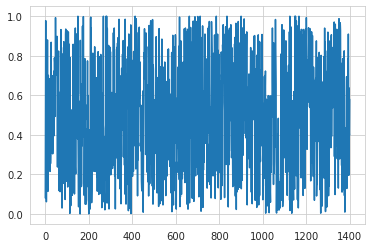

In [17]:
sns.lineplot(data=CSP[0][0])

In [20]:
CSP_RANGE = range(len(CSP))
PS_EQ = np.array([CSP[i][i] for i in CSP_RANGE]).mean(axis=0)
PS_NEQ = np.array([CSP[i][j] for i in CSP_RANGE for j in CSP_RANGE if i != j]).mean(axis=0)
PS_DIFF = PS_EQ - PS_NEQ

<AxesSubplot:>

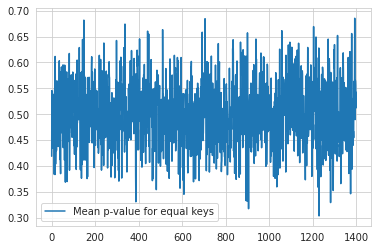

In [21]:
from pandas import DataFrame as Df

sns.lineplot(data=Df(PS_EQ, columns=["Mean p-value for equal keys"]))

<AxesSubplot:>

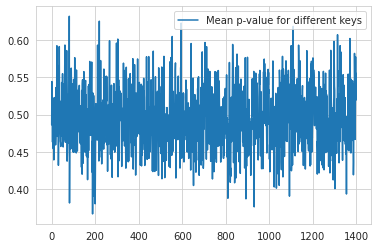

In [22]:
sns.lineplot(data=Df(PS_NEQ, columns=["Mean p-value for different keys"]))

<AxesSubplot:>

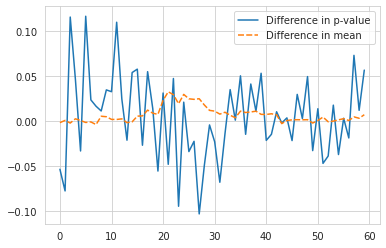

In [23]:
MOMENT_DIFF = cache_np("moment_differences", v=4)
sns.lineplot(data=Df({"Difference in p-value": PS_DIFF[40:100], "Difference in mean": MOMENT_DIFF[1][40:100]}))

#### Mean values for $p$ and moving average.

In [13]:
(PS_EQ-PS_NEQ).mean()

0.505957417763956

<AxesSubplot:>

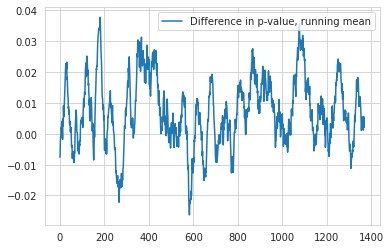

In [24]:
def running_mean(x, n):
    cs = np.cumsum(np.insert(x, 0, 0))
    return (cs[n:] - cs[:-n]) / float(n)

PS_RM = running_mean(PS_DIFF, 30)
sns.lineplot(data=Df(PS_RM, columns=["Difference in p-value, running mean"]))

If there is a leakage, traces with equal keys should show dependence and
traces that have different keys should show independence.

The mean $p$-value for traces with equal keys is *slightly* higher than the mean $p$-value for non-equal keys
(especially at the first rounds).

Small $p$ values give evidence to reject the null hypothesis and conclude that the observations are not independent.

Concluding from this $\chi^2$-test the sample points from same-key traces show less dependence than the sample points
from different-key traces. Which leads me to conclude that there is no leakage.
